# Inbound Foreigner Stats from openapi and KTO
### |     LIST     |
### 1. xml connect
### 2. preprocess
### 3. DataFrame
### 4. Visualize
### 5. fit and predict for furture

## 1. xml connect

In [727]:
from urllib.parse import urlencode, quote_plus
from urllib.request import urlopen
import requests
import pandas as pd
import numpy as np
from call_key import call

sKey = call()
def call_xml(YM, NAT_CD="", TRA_PURP_CD="", PORT_CD="", SEX_CD="", AGE_CD="",pageNo=""):
    url = 'http://openapi.tour.go.kr/openapi/service/EdrcntTourismStatsService/getForeignTuristStatsList'
    queryParams = '?' + urlencode({
        quote_plus('YM') : YM,
        quote_plus('NAT_CD') : NAT_CD,
        quote_plus('AGE_CD') : AGE_CD,
        quote_plus('TRA_PURP_CD') : TRA_PURP_CD,
        quote_plus('PORT_CD') : PORT_CD,
        quote_plus('SEX_CD') : SEX_CD,
        quote_plus('serviceKey') : sKey
        # quote_plus('pageNo') : pageNo
        # quote_plus('numOfRows') : "30"
        })
    response = requests.get(url+queryParams).text
    return response

# each xml response has 10 row by age
# making data with xml from openapi under allowed trafic

test = call_xml(YM="201902", NAT_CD=113, TRA_PURP_CD="02", PORT_CD="IA", SEX_CD="F")
# test1 = call_xml(YM="201902", NAT_CD=113, TRA_PURP_CD="02", PORT_CD="IA", pageNo=1)
# test2 = call_xml(YM="201902", NAT_CD=113, TRA_PURP_CD="02", PORT_CD="IA", pageNo=2)
# test3 = call_xml(YM="201902", NAT_CD=113, TRA_PURP_CD="02", PORT_CD="IA", pageNo=3)

In [728]:
# openapi has 10row/page rule, could handle pageNo, but can not change num of rows
print(test)
# print(f"test1:\n{test1}")
# print(f"test2:\n{test2}")
# print(f"test3:\n{test3}")

<?xml version="1.0" encoding="UTF-8" standalone="yes"?><response><header><resultCode>0000</resultCode><resultMsg>OK</resultMsg></header><body><items><item><age>0 - 10</age><ageCd>10</ageCd><natCd>113</natCd><natKorNm>대  만</natKorNm><num>1878</num><port>인천공항</port><portCd>IA</portCd><rnum>1</rnum><sex>여성</sex><sexCd>F</sexCd><traPurp>관광</traPurp><traPurpCd>02</traPurpCd><ym>201902</ym></item><item><age>11 - 20</age><ageCd>20</ageCd><natCd>113</natCd><natKorNm>대  만</natKorNm><num>4135</num><port>인천공항</port><portCd>IA</portCd><rnum>2</rnum><sex>여성</sex><sexCd>F</sexCd><traPurp>관광</traPurp><traPurpCd>02</traPurpCd><ym>201902</ym></item><item><age>21 - 30</age><ageCd>30</ageCd><natCd>113</natCd><natKorNm>대  만</natKorNm><num>9820</num><port>인천공항</port><portCd>IA</portCd><rnum>3</rnum><sex>여성</sex><sexCd>F</sexCd><traPurp>관광</traPurp><traPurpCd>02</traPurpCd><ym>201902</ym></item><item><age>31 - 40</age><ageCd>40</ageCd><natCd>113</natCd><natKorNm>대  만</natKorNm><num>8335</num><port>인천공항</por

In [729]:
# reference source from stackflow
# https://stackoverflow.com/questions/2148119/how-to-convert-an-xml-string-to-a-dictionary
# xml -> dic -> DataFrame

from xml.etree import cElementTree as ElementTree

class XmlListConfig(list):
    def __init__(self, aList):
        for element in aList:
            if element:
                # treat like dict
                if len(element) == 1 or element[0].tag != element[1].tag:
                    self.append(XmlDictConfig(element))
                # treat like list
                elif element[0].tag == element[1].tag:
                    self.append(XmlListConfig(element))
            elif element.text:
                text = element.text.strip()
                if text:
                    self.append(text)

class XmlDictConfig(dict):
    '''
    Example usage:

    >>> tree = ElementTree.parse('your_file.xml')
    >>> root = tree.getroot()
    >>> xmldict = XmlDictConfig(root)

    Or, if you want to use an XML string:

    >>> root = ElementTree.XML(xml_string)
    >>> xmldict = XmlDictConfig(root)

    And then use xmldict for what it is... a dict.
    '''
    def __init__(self, parent_element):
        if parent_element.items():
            self.update(dict(parent_element.items()))
        for element in parent_element:
            if element:
                # treat like dict - we assume that if the first two tags
                # in a series are different, then they are all different.
                if len(element) == 1 or element[0].tag != element[1].tag:
                    aDict = XmlDictConfig(element)
                # treat like list - we assume that if the first two tags
                # in a series are the same, then the rest are the same.
                else:
                    # here, we put the list in dictionary; the key is the
                    # tag name the list elements all share in common, and
                    # the value is the list itself 
                    aDict = {element[0].tag: XmlListConfig(element)}
                # if the tag has attributes, add those to the dict
                if element.items():
                    aDict.update(dict(element.items()))
                self.update({element.tag: aDict})
            # this assumes that if you've got an attribute in a tag,
            # you won't be having any text. This may or may not be a 
            # good idea -- time will tell. It works for the way we are
            # currently doing XML configuration files...
            elif element.items():
                self.update({element.tag: dict(element.items())})
            # finally, if there are no child tags and no attributes, extract
            # the text
            else:
                self.update({element.tag: element.text})

root = ElementTree.XML(test)
xmldict = XmlDictConfig(root)
df = pd.DataFrame(xmldict["body"]["items"].get("item"))
df

age ageCd natCd natKorNm   num  port portCd rnum sex sexCd traPurp  \
0   0 - 10    10   113     대  만  1878  인천공항     IA    1  여성     F      관광   
1  11 - 20    20   113     대  만  4135  인천공항     IA    2  여성     F      관광   
2  21 - 30    30   113     대  만  9820  인천공항     IA    3  여성     F      관광   
3  31 - 40    40   113     대  만  8335  인천공항     IA    4  여성     F      관광   
4  41 - 50    50   113     대  만  6875  인천공항     IA    5  여성     F      관광   
5  51 - 60    60   113     대  만  3790  인천공항     IA    6  여성     F      관광   
6  61 - 70    70   113     대  만  1424  인천공항     IA    7  여성     F      관광   
7     71 -    80   113     대  만   326  인천공항     IA    8  여성     F      관광   

  traPurpCd      ym  
0        02  201902  
1        02  201902  
2        02  201902  
3        02  201902  
4        02  201902  
5        02  201902  
6        02  201902  
7        02  201902

In [730]:
# test for loop by condition (list)

# YM_l = ["201901", "201902", "201903"]
# NAT_l = [113]
# TRA_P_l = ["02","03"]
# POR_l = ["IA"]
# SEX_l = ["F","M"]

# i = 1
# result = []
# for ym in YM_l :
#     for nat in NAT_l:
#         for tra_p in TRA_P_l:
#             for port in POR_l:
#                 for sex in SEX_l:
#                     test = call_xml(YM=ym, NAT_CD=nat, TRA_PURP_CD=tra_p, PORT_CD=port, SEX_CD=sex)
#                     result.append(test)
#                     #print(f"print{i}:\n", test)
#                     #i += 1
#                     # test += test

# print(result)

In [731]:
# test for xml -> dic
# tmp = []

# for xml in result:
#     root = ElementTree.XML(xml)
#     xmldict = XmlDictConfig(root)
#     pre_df = tmp.extend(xmldict["body"]["items"].get("item"))

# print(tmp)

In [732]:
# test for dic > DataFrame
# df = pd.DataFrame(tmp)
# df

In [733]:
# make nat_list for for_loop

NAT = """
000=미상
100=한  국
101=아프가니스탄
104=바레인
105=방글라데시
106=부  탄
107=브루나이
108=미얀마
109=영령 인도양섬
110=캄보디아
111=스리랑카
112=중  국
113=대  만
114=키프로스
118=북  한
120=홍  콩
121=홍콩난민
124=인  도
125=인도네시아
126=이  란
127=이라크
128=이스라엘
130=일  본
131=요르단
133=카자흐스탄
134=키르기스스탄
135=쿠웨이트
138=라오스
139=레바논
142=마카오
143=말레이시아
144=몰디브
145=몽  골
146=마요트
148=네  팔
150=오  만
153=파키스탄
154=팔레스타인
155=필리핀
156=티모르
159=카타르
162=사우디아라비아
163=시킴왕국
164=싱가포르
165=시리아
169=타지키스탄
170=태  국
171=터  키
172=투르크메니스탄
180=아랍에미리트연합
181=우즈베키스탄
185=베트남
191=예멘공화국
192=예멘인민민주공화국
200=앵귈라
201=앤티가 바부다
202=아르헨티나
203=아루바
205=바하마
206=바베이도스
207=벨리즈
208=볼리비아
209=브라질
210=버뮤다
211=부베트
212=케이맨 제도
213=캐나다
214=칠  레
215=콜롬비아
216=코스타리카
217=쿠  바
220=도미니카연방
221=도미니카공화국
223=이스터 제도
224=에콰도르
225=엘살바도르
226=포클랜드
227=불령 가이아나
229=그레나다
230=과들루프
231=과테말라
232=가이아나
235=아이티
236=온두라스
240=자메이카
247=마르티니크
248=멕시코
249=몬서래트
251=네덜란드령 앤틸리스
252=니카라과
255=파나마
256=파라과이
257=페  루
258=푸에르토리코
260=남조지아 남샌드위치 군도
261=상피에르 미클롱
262=세인트크리스토퍼 네비스
263=세인트루시아
264=세인트빈센트 그레나딘
265=수리남
268=트리니다드토바고
269=터크스케이커스
274=우루과이
275=미  국
276=미국인근섬
280=베네수엘라
281=미령 버진아일랜드
282=영령 버진아일랜드
301=알바니아
302=안도라
303=오스트리아
304=아르메니아
305=아제르바이잔
306=벨기에
307=불가리아
308=벨로루시
309=보스니아-헤르체고비나
310=체  코
311=페로 섬
312=에스토니아
313=덴마크
314=영국 보호민
315=영국 속국민
316=영  국
317=영국 속령지 시민
318=영국 외지민
319=영국 외지시민
320=핀란드
321=프랑스
323=그루지야
324=독  일
325=동  독
326=그리스
327=지브롤터
328=그린란드
329=헝가리
333=아이슬란드
334=아일랜드
335=이탈리아
337=코소보
339=라트비아
340=리히텐슈타인
341=룩셈부르크
342=리투아니아
343=마케도니아
344=몰  타
345=모나코
346=몰도바
347=몬테네그로
350=네덜란드
352=노르웨이
360=폴란드
361=포르투갈
365=루마니아
366=러시아(연방)
367=세르비아
368=슬로바크
370=슬로베니아
371=산마리노
372=스페인
373=스웨덴
374=스위스
375=스발바르
378=우크라이나
380=독립국가연합
390=바티칸
391=크로아티아
395=유고슬라비아
396=세르비아 앤 몬테네그로
404=오스트레일리아
411=캐롤라인 군도
412=쿡아일랜드
413=크리스마스
414=코코스
418=피  지
419=불령 폴리네시아
420=불령 남태평양섬
423=괌
425=허드 맥도날드
429=키리바시
434=북마리아나 군도
435=미크로네시아
436=마라아나 군도
437=마샬군도
438=미드웨이
441=나우루
443=뉴칼레도니아
446=뉴질랜드
447=니우에
448=노폴크
451=팔라우
452=파푸아뉴기니
454=핏캐른
461=사모아
462=미령 사모아
463=솔로몬군도
464=호주령 솔로몬군도
473=통  가
474=토켈라우
475=투발루
485=비누아투
490=웨이크아일랜드
491=월리스푸투나
502=알제리
503=앙골라
506=보츠와나
507=부룬디
510=카메룬
511=카나리아군도
512=카보베르데
513=중앙 아프리카 공화국
514=차  드
515=코모로
516=콩  고
517=콩고 민주공화국
520=베  냉
521=지부티
525=이집트
526=적도기니
527=에티오피아
528=에리트레아
530=가  봉
531=감비아
532=가  나
533=기  니
534=기니비사우
537=코트디부아르
540=케  냐
542=레소토
543=라이베리아
544=리비아
550=마다가스카르
551=말라위
552=말  리
553=모리타니
554=모리셔스
555=모로코
556=모잠비크
560=나미비아
561=니제르
562=나이지리아
564=레위니옹
565=짐바브웨
566=르완다
571=상투메 프린시페
572=세네갈
573=세이셸
574=시에라리온
575=소말리아
576=남아프리카 공화국
577=세인트헬레나
578=수  단
579=스와질란드
580=남수단공화국
583=탄자니아
584=토  고
585=튀니지
588=우간다
589=부르키나파소
591=서사하라
594=자이르
595=잠비아
620=남극대륙
666=공해
900=국제연합
998=승무원
999=교포"""

re_nat = NAT.split("\n")
nat_result = []
for nat in re_nat:
    nat_result.append(nat[0:3])
nat_list = nat_result[1:]
print(len(nat_list))
print(nat_list)

267
['000', '100', '101', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '118', '120', '121', '124', '125', '126', '127', '128', '130', '131', '133', '134', '135', '138', '139', '142', '143', '144', '145', '146', '148', '150', '153', '154', '155', '156', '159', '162', '163', '164', '165', '169', '170', '171', '172', '180', '181', '185', '191', '192', '200', '201', '202', '203', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '220', '221', '223', '224', '225', '226', '227', '229', '230', '231', '232', '235', '236', '240', '247', '248', '249', '251', '252', '255', '256', '257', '258', '260', '261', '262', '263', '264', '265', '268', '269', '274', '275', '276', '280', '281', '282', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '323', '324', '325', '326', '327', '328', '329', '333', '334', '335', '337', '339', '340', '

In [734]:
# make sex, age, tra_purp lists for for_loop

sex_list = ["C", "F", "M"]
age_list = [10,20,30,40,50,60,70,80,99]
tra_p_list = ["01","02","03","04","05","06","07","08","09","99"]

In [735]:
# make port_list for for_loop

PORT = """
P9=공항기타
V9=항구기타
BP=반포도심
CC=춘  천
CH=전  주
CJ=제  주
CU=청  주
DR=도라산
DS=도  심
GC=감  천
GP=김포공항
GS=고  성
IA=인천공항
IC=인  천
KE=거  제
KH=김  해
KJ=광  주
KP=김  포
KS=군  산
KY=광  양
MP=목  포
MS=마  산
OS=오  산
PH=포  항
PM=판문점
PS=부  산
PT=평  택
SA=보호소
SB=세종로
SC=사  천
SN=성  남
SO=속  초
SU=서  울
TG=대  구
TH=동  해
TJ=대  전
TS=대  산
TY=통  영
UJ=의정부
US=울  산
YA=양양공항
YS=여  수
MA=무  안
IP=정보팀
KC=기타"""

re_port = PORT.split("\n")
port_result = []
for port in re_port:
    port_result.append(port[0:2])
port_list = port_result[1:]
print(len(port_list))
print(port_list)


45
['P9', 'V9', 'BP', 'CC', 'CH', 'CJ', 'CU', 'DR', 'DS', 'GC', 'GP', 'GS', 'IA', 'IC', 'KE', 'KH', 'KJ', 'KP', 'KS', 'KY', 'MP', 'MS', 'OS', 'PH', 'PM', 'PS', 'PT', 'SA', 'SB', 'SC', 'SN', 'SO', 'SU', 'TG', 'TH', 'TJ', 'TS', 'TY', 'UJ', 'US', 'YA', 'YS', 'MA', 'IP', 'KC']


In [736]:
# num of parameter multi
print(len(sex_list) * len(tra_p_list) * len(port_list) * len(nat_list))
print(len(sex_list) * len(tra_p_list) * len(port_list))

360450
1350


In [737]:
# loop by condition (list)

YM_l = ["201901"]
NAT_l = [113]
TRA_P_l = tra_p_list
POR_l = port_list
SEX_l = sex_list

results = []
#  for ym in YM_l :
#     for nat in NAT_l:
#         for tra_p in TRA_P_l:
#             for port in POR_l:
#                 for sex in SEX_l:
#                     res_xml = call_xml(YM=ym, NAT_CD=nat, TRA_PURP_CD=tra_p, PORT_CD=port, SEX_CD=sex)
#                     results.append(res_xml)


In [738]:
print(results)

[]


In [739]:
# xml -> dic
tmp = []

for xml in results:
    root = ElementTree.XML(xml)
    xmldict = XmlDictConfig(root)
    tmp.extend(xmldict["body"]["items"].get("item"))

print(tmp)

[]


In [740]:
# dic > DataFrame -> csv
# cannot assignment reason why over trafic limit (openapi)
# df = pd.DataFrame(tmp)
# df.to_csv(f'./{YM_l}&{NAT_l}.csv', sep=',', na_rep='NaN')

In [741]:
read = pd.read_csv("./['201901']&[113].csv")
read

Unnamed: 0      age  ageCd  natCd natKorNm   num  port portCd  rnum sex  \
0            0   0 - 10     10    113     대  만  2391  인천공항     IA     1  여성   
1            1  11 - 20     20    113     대  만  5192  인천공항     IA     2  여성   
2            2  21 - 30     30    113     대  만  9192  인천공항     IA     3  여성   
3            3  31 - 40     40    113     대  만  8807  인천공항     IA     4  여성   
4            4  41 - 50     50    113     대  만  7888  인천공항     IA     5  여성   
..         ...      ...    ...    ...      ...   ...   ...    ...   ...  ..   
73          73  31 - 40     40    113     대  만     9  인천공항     IA     2  남성   
74          74  41 - 50     50    113     대  만    12  인천공항     IA     3  남성   
75          75  51 - 60     60    113     대  만     7  인천공항     IA     4  남성   
76          76  61 - 70     70    113     대  만     1  인천공항     IA     5  남성   
77          77     71 -     80    113     대  만     0  인천공항     IA     6  남성   

   sexCd traPurp  traPurpCd      ym  
0      F      관광          2  201901  
1      F      관광          2  201901  
2      F      관광          2  201901  
3      F      관광          2  201901  
4      F      관광          2  201901  
..   ...     ...        ...     ...  
73     M      상용          3  201903  
74     M      상용          3  201903  
75     M      상용          3  201903  
76     M      상용          3  201903  
77     M      상용          3  201903  

[78 rows x 14 columns]

In [742]:
# csv -> text book data structure
pivoted = pd.pivot_table(read,index=["natKorNm","natCd","ym"],columns=["traPurp","sex"],values=["num"],aggfunc=np.sum,margins=True)
pivoted

num                         
traPurp                   관광           상용         All
sex                       남성      여성   남성  여성        
natKorNm natCd ym                                    
대  만     113   201901  20871   37878   26  20   58795
               201902  21840   36583   58  22   58503
               201903  17265   37579   30  15   54889
All                    59976  112040  114  57  172187

In [743]:
# pivoted data -> csv
pivoted.to_csv(f'./pivoted_{YM_l}&{NAT_l}.csv', sep=',', na_rep='NaN')

## 2. preprocess

In [744]:
# under openapi trafic limit, can not make whole data thru api and xml
# therefore, using data set and csv what were given from text book git hub 

# read csv and check well read
kto_201901 = pd.read_excel('/Volumes/Geozedo60/Python/bit/datamath/practice/datasalon/02_개정판/4_Tourists_Event/files/kto_201901.xlsx', 
                          header=1,
                          usecols='A:G',
                          skipfooter=4)
kto_201901.head()

국적      관광     상용    공용  유학/연수      기타       계
0  아시아주  765082  10837  1423  14087  125521  916950
1    일본  198805   2233   127    785    4576  206526
2    대만   86393     74    22    180    1285   87954
3    홍콩   34653     59     2     90    1092   35896
4   마카오    2506      2     0     17      45    2570

In [745]:
kto_201901.tail()

국적   관광   상용  공용  유학/연수     기타      계
62  아프리카 기타  768  718  90    206    908   2690
63     기타대륙   33    4   0      1     16     54
64     국적미상   33    4   0      1     16     54
65     교포소계    0    0   0      0  15526  15526
66       교포    0    0   0      0  15526  15526

In [746]:
# summarize data
kto_201901.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   국적      67 non-null     object
 1   관광      67 non-null     int64 
 2   상용      67 non-null     int64 
 3   공용      67 non-null     int64 
 4   유학/연수   67 non-null     int64 
 5   기타      67 non-null     int64 
 6   계       67 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 3.8+ KB


In [747]:
kto_201901.describe()

관광            상용           공용         유학/연수             기타  \
count      67.00000     67.000000    67.000000     67.000000      67.000000   
mean    26396.80597    408.208955   132.507463    477.462687    5564.208955   
std    102954.04969   1416.040302   474.406339   2009.484800   17209.438418   
min         0.00000      0.000000     0.000000      0.000000      16.000000   
25%       505.00000     14.500000     2.500000     17.500000     260.000000   
50%      1304.00000     45.000000    14.000000     43.000000     912.000000   
75%      8365.00000    176.500000    38.000000    182.000000    2824.500000   
max    765082.00000  10837.000000  2657.000000  14087.000000  125521.000000   

                   계  
count      67.000000  
mean    32979.194030  
std    122821.369969  
min        54.000000  
25%       927.000000  
50%      2695.000000  
75%     14905.500000  
max    916950.000000

In [748]:
# filter by condition (0 value on any columns)
condition = (kto_201901["관광"]==0) \
            | (kto_201901["상용"]==0) \
            | (kto_201901["공용"]==0) \
            | (kto_201901["유학/연수"]==0)
kto_201901[condition]

국적    관광   상용  공용  유학/연수     기타      계
4      마카오  2506    2   0     17     45   2570
20    이스라엘   727   12   0      9     57    805
22  우즈베키스탄  1958  561   0    407   2828   5754
38     스위스   613   18   0     19     97    747
45     그리스   481   17   4      0    273    775
46    포르투갈   416   14   0     13    121    564
51   크로아티아   226   12   0      3    250    491
54     폴란드   713   10   0     27    574   1324
59  대양주 기타   555    3   4      0     52    614
63    기타대륙    33    4   0      1     16     54
64    국적미상    33    4   0      1     16     54
65    교포소계     0    0   0      0  15526  15526
66      교포     0    0   0      0  15526  15526

In [749]:
# append new column as year_month
kto_201901["기준년월"] = "2019-01"
kto_201901.head()

국적      관광     상용    공용  유학/연수      기타       계     기준년월
0  아시아주  765082  10837  1423  14087  125521  916950  2019-01
1    일본  198805   2233   127    785    4576  206526  2019-01
2    대만   86393     74    22    180    1285   87954  2019-01
3    홍콩   34653     59     2     90    1092   35896  2019-01
4   마카오    2506      2     0     17      45    2570  2019-01

In [750]:
# column list except overlapping
kto_201901["국적"].unique()

array(['아시아주', '일본', '대만', '홍콩', '마카오', '태국', '말레이시아', '필리핀', '인도네시아',
       '싱가포르', '미얀마', '베트남', '인도', '스리랑카', '파키스탄', '방글라데시', '캄보디아', '몽골',
       '중국', '이란', '이스라엘', '터키', '우즈베키스탄', '카자흐스탄', 'GCC', '아시아 기타', '미주',
       '미국', '캐나다', '멕시코', '브라질', '미주 기타', '구주', '영국', '독일', '프랑스',
       '네덜란드', '스웨덴', '스위스', '이탈리아', '덴마크', '노르웨이', '벨기에', '오스트리아', '스페인',
       '그리스', '포르투갈', '핀란드', '아일랜드', '우크라이나', '러시아', '크로아티아', '루마니아',
       '불가리아', '폴란드', '구주 기타', '대양주', '오스트레일리아', '뉴질랜드', '대양주 기타',
       '아프리카주', '남아프리카공화국', '아프리카 기타', '기타대륙', '국적미상', '교포소계', '교포'],
      dtype=object)

In [751]:
# need to cut out continents column
# ex) *주, 교포
continents = ["아시아주","구주","미주","대양주","아프리카주","교포소계","기타대륙"]
continents

['아시아주', '구주', '미주', '대양주', '아프리카주', '교포소계', '기타대륙']

In [752]:
# get rid of continents level
kto_201901_nat = kto_201901[kto_201901["국적"].isin(continents)==False]
kto_201901_nat

국적      관광    상용    공용  유학/연수     기타       계     기준년월
1         일본  198805  2233   127    785   4576  206526  2019-01
2         대만   86393    74    22    180   1285   87954  2019-01
3         홍콩   34653    59     2     90   1092   35896  2019-01
4        마카오    2506     2     0     17     45    2570  2019-01
5         태국   34004    37   199     96   6998   41334  2019-01
6      말레이시아   19043    95     7     99   2821   22065  2019-01
7        필리핀   14279   211   161    184  15638   30473  2019-01
8      인도네시아   14183   136    38    187   4298   18842  2019-01
9       싱가포르    8372    94     8     48   1333    9855  2019-01
10       미얀마    1304    10    31     67   3877    5289  2019-01
11       베트남   10739   763   110   1667   6904   20183  2019-01
12        인도    2318  2656    46    177   3474    8671  2019-01
13      스리랑카     157    54     5     28   1043    1287  2019-01
14      파키스탄     238   178    10    193    413    1032  2019-01
15     방글라데시     149   126    27     97    848    1247  2019-01
16      캄보디아     635    39    55     51   1915    2695  2019-01
17        몽골    8358    77   304    484    562    9785  2019-01
18        중국  320113  2993   138   8793  60777  392814  2019-01
19        이란      60    45    10     23     46     184  2019-01
20      이스라엘     727    12     0      9     57     805  2019-01
21        터키     792    13    32     36    912    1785  2019-01
22    우즈베키스탄    1958   561     0    407   2828    5754  2019-01
23     카자흐스탄    2185    24     7     92   1266    3574  2019-01
24       GCC    1550    37    14     72    103    1776  2019-01
25    아시아 기타    1561   308    70    205   2410    4554  2019-01
27        미국   42989   418  2578    229  16523   62737  2019-01
28       캐나다    8034    57    30     43   4296   12460  2019-01
29       멕시코    1282    11     7     38    515    1853  2019-01
30       브라질    1136    16     9     41    403    1605  2019-01
31     미주 기타    1541    24    33    128    540    2266  2019-01
33        영국    7982   175    17     41   1933   10148  2019-01
34        독일    4925   278    19    177   1451    6850  2019-01
35       프랑스    3773   297    48    288   1168    5574  2019-01
36      네덜란드    1592    47    16     77    537    2269  2019-01
37       스웨덴     844    29     6     18     85     982  2019-01
38       스위스     613    18     0     19     97     747  2019-01
39      이탈리아    1968    83    17     40    623    2731  2019-01
40       덴마크     520    21     6     16    188     751  2019-01
41      노르웨이     552    66     4     28    151     801  2019-01
42       벨기에     490    24     4     22    169     709  2019-01
43     오스트리아     544     8     2     13    209     776  2019-01
44       스페인    1010    36    15     52    255    1368  2019-01
45       그리스     481    17     4      0    273     775  2019-01
46      포르투갈     416    14     0     13    121     564  2019-01
47       핀란드     412    23     1     18    405     859  2019-01
48      아일랜드     392    15     1      2    185     595  2019-01
49     우크라이나     593    58     3     28   1580    2262  2019-01
50       러시아   17260   181    37    191   7525   25194  2019-01
51     크로아티아     226    12     0      3    250     491  2019-01
52      루마니아     412     8     4      3    445     872  2019-01
53      불가리아     154     1     1     10    265     431  2019-01
54       폴란드     713    10     0     27    574    1324  2019-01
55     구주 기타    1809    44    25     91    996    2965  2019-01
57   오스트레일리아   12795    93    17     34   1346   14285  2019-01
58      뉴질랜드    2029    20    17      5    654    2725  2019-01
59    대양주 기타     555     3     4      0     52     614  2019-01
61  남아프리카공화국     368     9     1      6    616    1000  2019-01
62   아프리카 기타     768   718    90    206    908    2690  2019-01
64      국적미상      33     4     0      1     16      54  2019-01
66        교포       0     0     0      0  15526   15526  2019-01

In [753]:
# reset index
kto_201901_nat_newidx = kto_201901_nat.reset_index(drop=True)
kto_201901_nat_newidx

국적      관광    상용    공용  유학/연수     기타       계     기준년월
0         일본  198805  2233   127    785   4576  206526  2019-01
1         대만   86393    74    22    180   1285   87954  2019-01
2         홍콩   34653    59     2     90   1092   35896  2019-01
3        마카오    2506     2     0     17     45    2570  2019-01
4         태국   34004    37   199     96   6998   41334  2019-01
5      말레이시아   19043    95     7     99   2821   22065  2019-01
6        필리핀   14279   211   161    184  15638   30473  2019-01
7      인도네시아   14183   136    38    187   4298   18842  2019-01
8       싱가포르    8372    94     8     48   1333    9855  2019-01
9        미얀마    1304    10    31     67   3877    5289  2019-01
10       베트남   10739   763   110   1667   6904   20183  2019-01
11        인도    2318  2656    46    177   3474    8671  2019-01
12      스리랑카     157    54     5     28   1043    1287  2019-01
13      파키스탄     238   178    10    193    413    1032  2019-01
14     방글라데시     149   126    27     97    848    1247  2019-01
15      캄보디아     635    39    55     51   1915    2695  2019-01
16        몽골    8358    77   304    484    562    9785  2019-01
17        중국  320113  2993   138   8793  60777  392814  2019-01
18        이란      60    45    10     23     46     184  2019-01
19      이스라엘     727    12     0      9     57     805  2019-01
20        터키     792    13    32     36    912    1785  2019-01
21    우즈베키스탄    1958   561     0    407   2828    5754  2019-01
22     카자흐스탄    2185    24     7     92   1266    3574  2019-01
23       GCC    1550    37    14     72    103    1776  2019-01
24    아시아 기타    1561   308    70    205   2410    4554  2019-01
25        미국   42989   418  2578    229  16523   62737  2019-01
26       캐나다    8034    57    30     43   4296   12460  2019-01
27       멕시코    1282    11     7     38    515    1853  2019-01
28       브라질    1136    16     9     41    403    1605  2019-01
29     미주 기타    1541    24    33    128    540    2266  2019-01
30        영국    7982   175    17     41   1933   10148  2019-01
31        독일    4925   278    19    177   1451    6850  2019-01
32       프랑스    3773   297    48    288   1168    5574  2019-01
33      네덜란드    1592    47    16     77    537    2269  2019-01
34       스웨덴     844    29     6     18     85     982  2019-01
35       스위스     613    18     0     19     97     747  2019-01
36      이탈리아    1968    83    17     40    623    2731  2019-01
37       덴마크     520    21     6     16    188     751  2019-01
38      노르웨이     552    66     4     28    151     801  2019-01
39       벨기에     490    24     4     22    169     709  2019-01
40     오스트리아     544     8     2     13    209     776  2019-01
41       스페인    1010    36    15     52    255    1368  2019-01
42       그리스     481    17     4      0    273     775  2019-01
43      포르투갈     416    14     0     13    121     564  2019-01
44       핀란드     412    23     1     18    405     859  2019-01
45      아일랜드     392    15     1      2    185     595  2019-01
46     우크라이나     593    58     3     28   1580    2262  2019-01
47       러시아   17260   181    37    191   7525   25194  2019-01
48     크로아티아     226    12     0      3    250     491  2019-01
49      루마니아     412     8     4      3    445     872  2019-01
50      불가리아     154     1     1     10    265     431  2019-01
51       폴란드     713    10     0     27    574    1324  2019-01
52     구주 기타    1809    44    25     91    996    2965  2019-01
53   오스트레일리아   12795    93    17     34   1346   14285  2019-01
54      뉴질랜드    2029    20    17      5    654    2725  2019-01
55    대양주 기타     555     3     4      0     52     614  2019-01
56  남아프리카공화국     368     9     1      6    616    1000  2019-01
57   아프리카 기타     768   718    90    206    908    2690  2019-01
58      국적미상      33     4     0      1     16      54  2019-01
59        교포       0     0     0      0  15526   15526  2019-01

In [754]:
# categorize by continents

import requests
from bs4 import BeautifulSoup

# h2 = conti
# h3 = conti + NEWS
# ul = nations

results_nat = []
def crawler():
    url = 'https://ko.wikipedia.org/w/index.php?title=%EB%8C%80%EB%A5%99%EB%B3%84_%EB%82%98%EB%9D%BC_%EB%AA%A9%EB%A1%9D'
    html = requests.get(url)
    # soup = BeautifulSoup(html, 'html.parser')
    soup = BeautifulSoup(html.text, "html.parser")
    # select = soup.find_all("h2")
    # print(select)
    # select_conti = soup.find_all("span", attrs={"class":"mw-headline"})
    # select_conti = soup.find("div", attrs={"class":"mw-parser-output"}).find("h2").find_all("span", attrs={"class":"mw-headline"})
    # print(select_conti)
    select_nat = soup.find("div", attrs={"class":"mw-parser-output"}).find_all("li")
    # print(select_nat[33].find_all("a",limit=2)[1].get_text("title"))
    # for meta in select_conti:
    #     print(meta.get("id"))
    for meta in select_nat:
        try :
            meta.find_all("a",limit=2)[1].get_text("title")
        except:
            continue
        else :
            results_nat.append(meta.find_all("a",limit=2)[1].get_text("title"))

crawler()

# if wikipedia info has been changed, have to modify slice standard (from to end+1)
asia_s = slice(results_nat.index("대한민국"),results_nat.index("코모로"))
africa_s = slice(results_nat.index("코모로"),results_nat.index("포르투갈"))
europe_s = slice(results_nat.index("포르투갈"),results_nat.index("미국"))
america_s = slice(results_nat.index("미국"),results_nat.index("괌"))
oceania_s = slice(results_nat.index("괌"),results_nat.index("체첸 공화국"))
etc_s = slice(results_nat.index("체첸 공화국"), results_nat.index("로자바")+1)
c_s = slice(results_nat.index("체첸 공화국"), results_nat.index("로자바")+1)

asia = results_nat[asia_s] + ["아시아 기타", "홍콩", "대만", "마카오", "중국"]
africa = results_nat[africa_s] + ["아프리카 기타", "GCC", "남아프리카공화국"]
europe = results_nat[europe_s] + ["구주 기타"]
america = results_nat[america_s] + ["미주 기타"]
oceania = results_nat[oceania_s] + ["대양주 기타"]
etc = results_nat[etc_s] + ["국적미상"]
kr = ["교포"]

print(asia)
print(africa)
print(europe)
print(america)
print(oceania)
print(etc)
print(kr)

['대한민국', '조선민주주의인민공화국', '일본', '몽골', '중화인민공화국', '중화민국', '브루나이', '인도네시아', '캄보디아', '라오스', '말레이시아', '미얀마', '필리핀', '싱가포르', '태국', '동티모르', '베트남', '러시아', '네팔', '몰디브', '방글라데시', '부탄', '스리랑카', '인도', '파키스탄', '이란', '아프가니스탄', '우즈베키스탄', '카자흐스탄', '키르기스스탄', '타지키스탄', '투르크메니스탄', '레바논', '바레인', '사우디아라비아', '시리아', '아랍에미리트', '아르메니아', '아르차흐 공화국', '아제르바이잔', '예멘', '오만', '요르단', '이라크', '이스라엘', '카타르', '쿠웨이트', '키프로스', '북키프로스', '터키', '팔레스타인', '조지아', '세베로오세티야', '압하지야', '아시아 기타', '홍콩', '대만', '마카오', '중국']
['코모로', '지부티', '에리트레아', '에티오피아', '케냐', '세이셸', '소말리아', '소말릴란드', '탄자니아', '중앙아프리카 공화국', '콩고 민주 공화국', '우간다', '부룬디', '르완다', '남수단', '베냉', '부르키나파소', '카보베르데', '차드', '코트디부아르', '감비아', '가나', '기니', '기니비사우', '라이베리아', '말리', '모리타니', '니제르', '나이지리아', '비아프라', '세네갈', '시에라리온', '토고', '콩고 공화국', '적도 기니', '가봉', '카메룬', '상투메 프린시페', '알제리', '이집트', '리비아', '모로코', '수단', '튀니지', '사하라 아랍 민주 공화국', '앙골라', '보츠와나', '에스와티니', '레소토', '마다가스카르', '말라위', '모리셔스', '모잠비크', '나미비아', '남아프리카 공화국', '잠비아', '짐바브웨', '아프리카 기타', 'GCC', '남아프리카공화국']
['포르투갈', '몰타', '스페인', '산마리노'

In [755]:
# func for category
def cate_conti(value):
    if value in asia :
        return "asia"
    elif value in africa :
        return "africa"
    elif value in europe :
        return "europe"
    elif value in america :
        return "america"
    elif value in oceania :
        return "oceania"    
    elif value in etc :
        return "etc"
    elif value in kr :
        return "교포"
    else :
        print("please append new category")    

# way 1 for textbook
kto_201901_nat_newidx["대륙"] = kto_201901_nat_newidx["국적"].apply(cate_conti)
print(kto_201901_nat_newidx.head())

# check for null
print(kto_201901_nat_newidx[kto_201901_nat_newidx["대륙"].isnull()])

# way 2 for xml
new_nat = []
for nat in read["natKorNm"]:
    new_nat.append(cate_conti(nat.replace(" ","")))
read["continents"] = new_nat
print(read.head())

# check for null
print(read[read["continents"].isnull()])



    국적      관광    상용   공용  유학/연수    기타       계     기준년월    대륙
0   일본  198805  2233  127    785  4576  206526  2019-01  asia
1   대만   86393    74   22    180  1285   87954  2019-01  asia
2   홍콩   34653    59    2     90  1092   35896  2019-01  asia
3  마카오    2506     2    0     17    45    2570  2019-01  asia
4   태국   34004    37  199     96  6998   41334  2019-01  asia
Empty DataFrame
Columns: [국적, 관광, 상용, 공용, 유학/연수, 기타, 계, 기준년월, 대륙]
Index: []
   Unnamed: 0      age  ageCd  natCd natKorNm   num  port portCd  rnum sex  \
0           0   0 - 10     10    113     대  만  2391  인천공항     IA     1  여성   
1           1  11 - 20     20    113     대  만  5192  인천공항     IA     2  여성   
2           2  21 - 30     30    113     대  만  9192  인천공항     IA     3  여성   
3           3  31 - 40     40    113     대  만  8807  인천공항     IA     4  여성   
4           4  41 - 50     50    113     대  만  7888  인천공항     IA     5  여성   

  sexCd traPurp  traPurpCd      ym continents  
0     F      관광          2  201901 

In [756]:
# "관광" rate 
kto_201901_nat_newidx["관광객비율"] = round(kto_201901_nat_newidx["관광"] / kto_201901_nat_newidx["계"] *100,1)
kto_201901_nat_newidx.head()

국적      관광    상용   공용  유학/연수    기타       계     기준년월    대륙  관광객비율
0   일본  198805  2233  127    785  4576  206526  2019-01  asia   96.3
1   대만   86393    74   22    180  1285   87954  2019-01  asia   98.2
2   홍콩   34653    59    2     90  1092   35896  2019-01  asia   96.5
3  마카오    2506     2    0     17    45    2570  2019-01  asia   97.5
4   태국   34004    37  199     96  6998   41334  2019-01  asia   82.3

In [757]:
# desc by "관광" rate
print(kto_201901_nat_newidx.sort_values(by="관광객비율", ascending=False).head())
print(kto_201901_nat_newidx.sort_values(by="관광객비율").head())

        국적      관광    상용   공용  유학/연수    기타       계     기준년월       대륙  관광객비율
1       대만   86393    74   22    180  1285   87954  2019-01     asia   98.2
3      마카오    2506     2    0     17    45    2570  2019-01     asia   97.5
2       홍콩   34653    59    2     90  1092   35896  2019-01     asia   96.5
0       일본  198805  2233  127    785  4576  206526  2019-01     asia   96.3
55  대양주 기타     555     3    4      0    52     614  2019-01  oceania   90.4
       국적   관광   상용  공용  유학/연수     기타      계     기준년월    대륙  관광객비율
59     교포    0    0   0      0  15526  15526  2019-01    교포    0.0
14  방글라데시  149  126  27     97    848   1247  2019-01  asia   11.9
12   스리랑카  157   54   5     28   1043   1287  2019-01  asia   12.2
13   파키스탄  238  178  10    193    413   1032  2019-01  asia   23.1
15   캄보디아  635   39  55     51   1915   2695  2019-01  asia   23.6


In [758]:
# "관광" rate by continents

kto_201901_nat_newidx.pivot_table(index="대륙", values="관광객비율", aggfunc="mean").sort_values(by="관광객비율", ascending=False)

관광객비율
대륙                
oceania  84.833333
america  68.200000
europe   63.613636
etc      61.100000
asia     58.872000
africa   50.900000
교포        0.000000

In [759]:
# filter by taiwan 

condition = (kto_201901_nat_newidx["국적"] == "대만")
kto_201901_nat_newidx[condition]

국적     관광  상용  공용  유학/연수    기타      계     기준년월    대륙  관광객비율
1  대만  86393  74  22    180  1285  87954  2019-01  asia   98.2

In [760]:
# sum of total tour visiting

tourist_sum = sum(kto_201901_nat_newidx["관광"])
tourist_sum

884293

In [761]:
# rate for tourist per total visiting

kto_201901_nat_newidx["전체비율"] = round(kto_201901_nat_newidx["관광"]/tourist_sum*100,1)
kto_201901_nat_newidx.sort_values(by="전체비율",ascending=False)

국적      관광    상용    공용  유학/연수     기타       계     기준년월       대륙  \
17        중국  320113  2993   138   8793  60777  392814  2019-01     asia   
0         일본  198805  2233   127    785   4576  206526  2019-01     asia   
1         대만   86393    74    22    180   1285   87954  2019-01     asia   
25        미국   42989   418  2578    229  16523   62737  2019-01  america   
2         홍콩   34653    59     2     90   1092   35896  2019-01     asia   
4         태국   34004    37   199     96   6998   41334  2019-01     asia   
5      말레이시아   19043    95     7     99   2821   22065  2019-01     asia   
47       러시아   17260   181    37    191   7525   25194  2019-01     asia   
6        필리핀   14279   211   161    184  15638   30473  2019-01     asia   
7      인도네시아   14183   136    38    187   4298   18842  2019-01     asia   
53   오스트레일리아   12795    93    17     34   1346   14285  2019-01  oceania   
10       베트남   10739   763   110   1667   6904   20183  2019-01     asia   
16        몽골    8358    77   304    484    562    9785  2019-01     asia   
26       캐나다    8034    57    30     43   4296   12460  2019-01  america   
30        영국    7982   175    17     41   1933   10148  2019-01   europe   
8       싱가포르    8372    94     8     48   1333    9855  2019-01     asia   
31        독일    4925   278    19    177   1451    6850  2019-01   europe   
32       프랑스    3773   297    48    288   1168    5574  2019-01   europe   
11        인도    2318  2656    46    177   3474    8671  2019-01     asia   
3        마카오    2506     2     0     17     45    2570  2019-01     asia   
36      이탈리아    1968    83    17     40    623    2731  2019-01   europe   
54      뉴질랜드    2029    20    17      5    654    2725  2019-01  oceania   
21    우즈베키스탄    1958   561     0    407   2828    5754  2019-01     asia   
22     카자흐스탄    2185    24     7     92   1266    3574  2019-01     asia   
23       GCC    1550    37    14     72    103    1776  2019-01   africa   
24    아시아 기타    1561   308    70    205   2410    4554  2019-01     asia   
52     구주 기타    1809    44    25     91    996    2965  2019-01   europe   
33      네덜란드    1592    47    16     77    537    2269  2019-01   europe   
29     미주 기타    1541    24    33    128    540    2266  2019-01  america   
41       스페인    1010    36    15     52    255    1368  2019-01   europe   
42       그리스     481    17     4      0    273     775  2019-01   europe   
15      캄보디아     635    39    55     51   1915    2695  2019-01     asia   
46     우크라이나     593    58     3     28   1580    2262  2019-01   europe   
51       폴란드     713    10     0     27    574    1324  2019-01   europe   
39       벨기에     490    24     4     22    169     709  2019-01   europe   
55    대양주 기타     555     3     4      0     52     614  2019-01  oceania   
57   아프리카 기타     768   718    90    206    908    2690  2019-01   africa   
40     오스트리아     544     8     2     13    209     776  2019-01   europe   
37       덴마크     520    21     6     16    188     751  2019-01   europe   
38      노르웨이     552    66     4     28    151     801  2019-01   europe   
35       스위스     613    18     0     19     97     747  2019-01   europe   
34       스웨덴     844    29     6     18     85     982  2019-01   europe   
9        미얀마    1304    10    31     67   3877    5289  2019-01     asia   
28       브라질    1136    16     9     41    403    1605  2019-01  america   
19      이스라엘     727    12     0      9     57     805  2019-01     asia   
20        터키     792    13    32     36    912    1785  2019-01     asia   
27       멕시코    1282    11     7     38    515    1853  2019-01  america   
12      스리랑카     157    54     5     28   1043    1287  2019-01     asia   
58      국적미상      33     4     0      1     16      54  2019-01      etc   
13      파키스탄     238   178    10    193    413    1032  2019-01     asia   
56  남아프리카공화국     368     9     1      6    616    1000  2019-01   africa   
18        이란      60    45    10     23     46     184  20

## 3. DataFrame

In [762]:
# expand data range : 1995.01-2021.03
# form has been changed, fix way to preprocess
new_col = ["년","월","대륙","국적","계","계_비율","관광","관광/전체_비율","상용","상용_비율","공용","공용_비율","유학연수","유학연수_비율","기타","기타_비율"]
raw = pd.read_csv('./kto_1995-2021.csv', names=new_col, header=1, escapechar=",")

raw = raw.drop(columns=["계_비율", "상용_비율","공용_비율","유학연수_비율","기타_비율"])

cut_year_idx = ["총 합계"]
for i in range(1995,2022):
    tmp = str(i) + " 소계"
    cut_year_idx.append(tmp)
# cut_mon_idx = []
# for i in range(1,13):
#     tmp = str(i) + " 소계"
#     cut_mon_idx.append(tmp)
# print(cut_mon_idx)

cut_mon_idx = ['01 소계', '02 소계', '03 소계', '04 소계', '05 소계', '06 소계', '07 소계', '08 소계', '09 소계', '10 소계', '11 소계', '12 소계']
cut_cont_idx = ["아시아 소계","아메리카 소계","유럽 소계","오세아니아 소계","아프리카 소계","기타 소계","교포 소계","소계"]

raw = raw[raw["년"].isin(cut_year_idx)==False]
raw = raw[raw["월"].isin(cut_mon_idx)==False]
raw = raw[raw["대륙"].isin(cut_cont_idx)==False]
raw = raw.reset_index(drop=True)
raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18678 entries, 0 to 18677
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   년         18678 non-null  object 
 1   월         18678 non-null  object 
 2   대륙        18678 non-null  object 
 3   국적        18678 non-null  object 
 4   계         18678 non-null  int64  
 5   관광        18678 non-null  int64  
 6   관광/전체_비율  18678 non-null  float64
 7   상용        18678 non-null  int64  
 8   공용        18678 non-null  int64  
 9   유학연수      18678 non-null  int64  
 10  기타        18678 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 1.6+ MB


In [763]:

# 기준년월
raw["기준년월_l"] = raw["년"]+raw["월"]+"01"
raw["기준년월_s"] = raw["년"]+"-"+raw["월"]

# 관광_계_비율 : 관광/계
raw["관광/계_비율"] = round(raw["관광"]/raw["계"] * 100, 2)
raw

년   월     대륙        국적       계      관광  관광/전체_비율    상용   공용  유학연수  \
0      1995  01    아시아        중국   11797    1394      0.83  1471   93    13   
1      1995  01    아시아        일본  112902  104359     62.38  5657  127   288   
2      1995  01    아시아        대만   11792   10990      6.57    16   14     7   
3      1995  01    아시아        홍콩   10721   10209      6.10    35    0     0   
4      1995  01    아시아       필리핀   11749    1313      0.78   156   44     4   
...     ...  ..    ...       ...     ...     ...       ...   ...  ...   ...   
18673  2021  02  오세아니아  오세아니아 기타      58       3      0.04     0    2     2   
18674  2021  02   아프리카  남아프리카공화국      70       0      0.00     0    0     1   
18675  2021  02   아프리카   아프리카 기타    1086      30      0.35   163   11   375   
18676  2021  02     기타      국적미상       6       6      0.07     0    0     0   
18677  2021  02     교포        교포     779       0      0.00     0    0     0   

          기타    기준년월_l   기준년월_s  관광/계_비율  
0       8826  19950101  1995-01    11.82  
1       2471  19950101  1995-01    92.43  
2        765  19950101  1995-01    93.20  
3        477  19950101  1995-01    95.22  
4      10232  19950101  1995-01    11.18  
...      ...       ...      ...      ...  
18673     51  20210201  2021-02     5.17  
18674     69  20210201  2021-02     0.00  
18675    507  20210201  2021-02     2.76  
18676      0  20210201  2021-02   100.00  
18677    779  20210201  2021-02     0.00  

[18678 rows x 14 columns]

In [764]:
# to_excel
raw.to_excel("./kto_total.xlsx", index=False)

In [765]:
# to_excel by nation

nat_list = raw["국적"].unique()
# print(nat_list)
# print(len(nat_list))

for nat in nat_list:
    condition = (raw["국적"] == nat)
    raw_filter = raw[condition]
    file_path = "./file/[국적별 관광객 데이터]{}.xlsx".format(nat)
    raw_filter.to_excel(file_path,index=False)


## 4. Visualize

In [766]:
# read resource
df = pd.read_excel("./kto_total.xlsx")
df

년  월     대륙        국적       계      관광  관광/전체_비율    상용   공용  유학연수  \
0      1995  1    아시아        중국   11797    1394      0.83  1471   93    13   
1      1995  1    아시아        일본  112902  104359     62.38  5657  127   288   
2      1995  1    아시아        대만   11792   10990      6.57    16   14     7   
3      1995  1    아시아        홍콩   10721   10209      6.10    35    0     0   
4      1995  1    아시아       필리핀   11749    1313      0.78   156   44     4   
...     ... ..    ...       ...     ...     ...       ...   ...  ...   ...   
18673  2021  2  오세아니아  오세아니아 기타      58       3      0.04     0    2     2   
18674  2021  2   아프리카  남아프리카공화국      70       0      0.00     0    0     1   
18675  2021  2   아프리카   아프리카 기타    1086      30      0.35   163   11   375   
18676  2021  2     기타      국적미상       6       6      0.07     0    0     0   
18677  2021  2     교포        교포     779       0      0.00     0    0     0   

          기타    기준년월_l   기준년월_s  관광/계_비율  
0       8826  19950101  1995-01    11.82  
1       2471  19950101  1995-01    92.43  
2        765  19950101  1995-01    93.20  
3        477  19950101  1995-01    95.22  
4      10232  19950101  1995-01    11.18  
...      ...       ...      ...      ...  
18673     51  20210201  2021-02     5.17  
18674     69  20210201  2021-02     0.00  
18675    507  20210201  2021-02     2.76  
18676      0  20210201  2021-02   100.00  
18677    779  20210201  2021-02     0.00  

[18678 rows x 14 columns]

In [767]:
# filter by "대만"
df_filter = df[df["국적"] == "대만"]
df_filter

년   월   대륙  국적      계     관광  관광/전체_비율  상용  공용  유학연수   기타    기준년월_l  \
2      1995   1  아시아  대만  11792  10990      6.57  16  14     7  765  19950101   
61     1995   2  아시아  대만  16685  15911      8.81  26   7    36  705  19950201   
120    1995   3  아시아  대만  10919  10153      4.97  43   5     8  710  19950301   
178    1995   4  아시아  대만  12090  11430      6.11  26  12     5  617  19950401   
237    1995   5  아시아  대만  10358   9538      4.40  33  10     9  768  19950501   
...     ...  ..  ...  ..    ...    ...       ...  ..  ..   ...  ...       ...   
18380  2020  10  아시아  대만    299     34      0.31  57   4    36  168  20201001   
18440  2020  11  아시아  대만    299     42      0.36  42   1    62  152  20201101   
18500  2020  12  아시아  대만    264     34      0.29  44   0    23  163  20201201   
18560  2021   1  아시아  대만    253     35      0.39  10   5    37  166  20210101   
18620  2021   2  아시아  대만    444     40      0.47  23   0   205  176  20210201   

        기준년월_s  관광/계_비율  
2      1995-01    93.20  
61     1995-02    95.36  
120    1995-03    92.98  
178    1995-04    94.54  
237    1995-05    92.08  
...        ...      ...  
18380  2020-10    11.37  
18440  2020-11    14.05  
18500  2020-12    12.88  
18560  2021-01    13.83  
18620  2021-02     9.01  

[314 rows x 14 columns]

In [768]:
# import matplotlib for font
from matplotlib import font_manager, rc
import platform

if platform.system() == "Windows":
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc("font", family = font_name)
elif platform.system() == "Darwin":
    rc("font", family = "AppleGothic")
else:
    print("Plases check your OS")

In [769]:
# import plt
import matplotlib.pyplot as plt

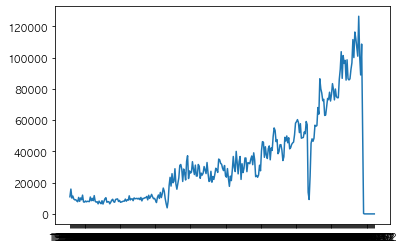

In [770]:
# simple plot
plt.plot(df_filter["기준년월_s"],df_filter["관광"])
plt.show()

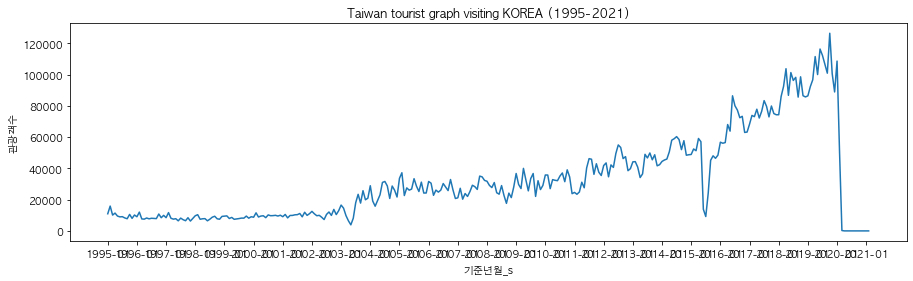

In [771]:
# deco plot
# size
plt.figure(figsize=(15,4))
# contents
plt.plot(df_filter["기준년월_s"],df_filter["관광"])
# title, label
plt.title("Taiwan tourist graph visiting KOREA (1995-2021)")
plt.xlabel("기준년월_s")
plt.ylabel("관광객수")
# x ticks
x_ticks = []
for i in range(1995,2022):
    tmp = str(i) + "-01"
    x_ticks.append(tmp)
plt.xticks(x_ticks)

plt.show()

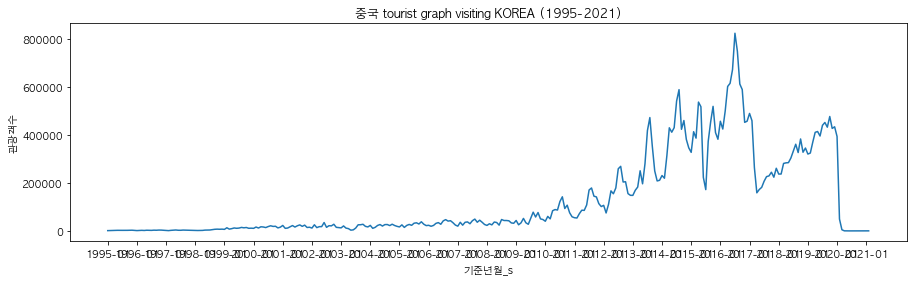

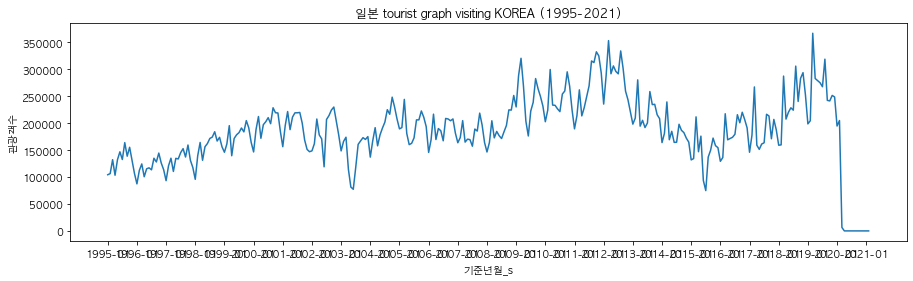

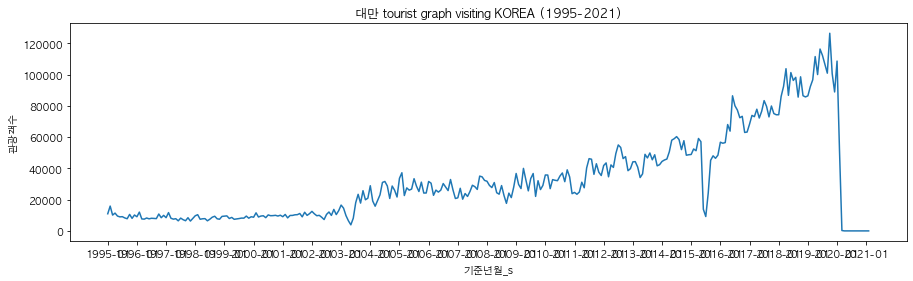

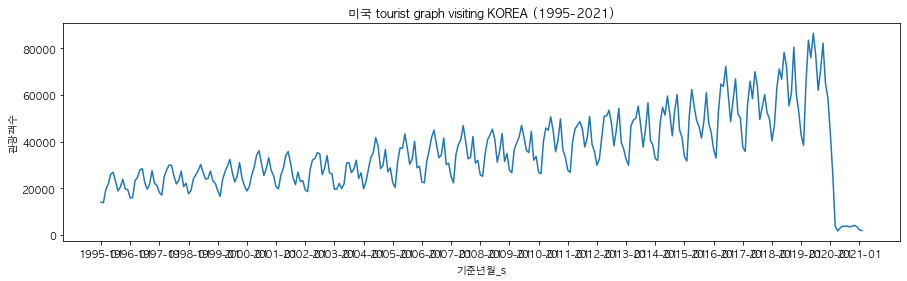

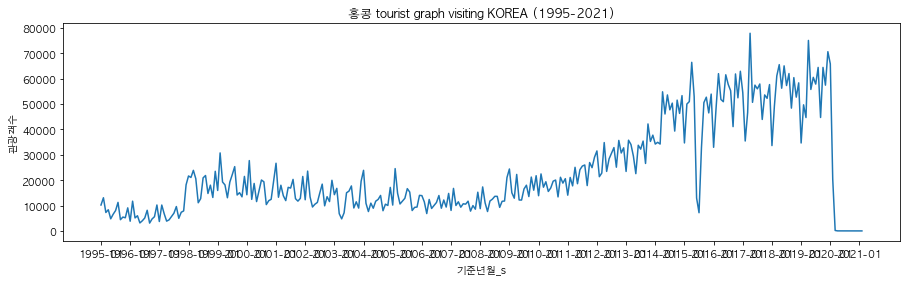

In [772]:
nat_list = ["중국", "일본", "대만", "미국", "홍콩"]

def tourist_nat_graph(nat):
    plt.figure(figsize=(15,4))
    df_filter = df[df["국적"] == nat]
    plt.plot(df_filter["기준년월_s"],df_filter["관광"])
    plt.title(f"{nat} tourist graph visiting KOREA (1995-2021)")
    plt.xlabel("기준년월_s")
    plt.ylabel("관광객수")
    x_ticks = []
    for i in range(1995,2022):
        tmp = str(i) + "-01"
        x_ticks.append(tmp)
    plt.xticks(x_ticks)
    plt.show()
    
for nat in nat_list:
    tourist_nat_graph(nat)

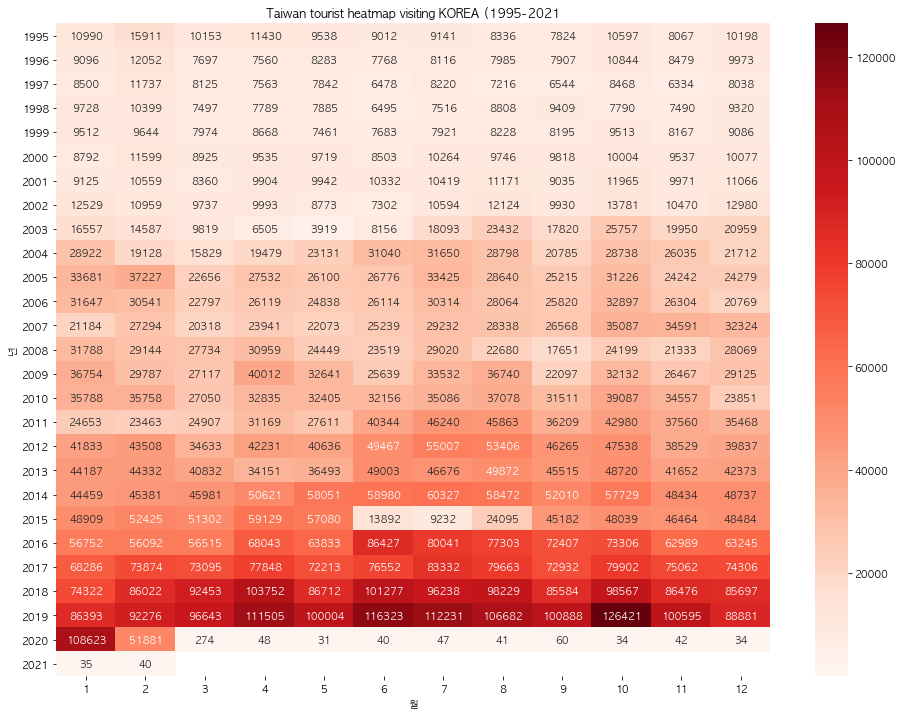

In [773]:
# heat map
import matplotlib.pyplot as plt
import seaborn as sns

df_filter = df[df["국적"] == "대만"]
df_pivot = df_filter.pivot_table(values="관광", index="년", columns="월")

# size
plt.figure(figsize=(16,12))
# heat map
sns.heatmap(df_pivot, annot=True, fmt=".0f", cmap="Reds")
# title
plt.title("Taiwan tourist heatmap visiting KOREA (1995-2021")

plt.show()

< Remark >
* Aviation Agreement
    - year 2004  : recover and restart since 1992, when KOR-TW had a break in diplomatic relations
    - year 2015 : flight count and size growing up
    - all airline service between KOR-TW, except AIR-SEOUL(RW)
    - Cathay Pacific(CX) service HKG-TPE-ICN
    
* VISA free since 2012/JULY (tourist for 90 days)
    - URL : https://news.kotra.or.kr/user/extra/mkotranews/nationInfo/nationItemMovileView/jsp/Page.do?cdKey=101085&categoryIdx=250

* 2019/OCT was Ten-Ten day(National day), 7C and TW serviced chartered flight and extra flight

* After THAAD located in korea, lot of inbound travel agency prefer TW tourist than mainland china
* TWD currency get worth than before and it made tourist more spend money (1TWD= 3x --> 4x)

* Holidays    
    - JAN/FEB : New year (Lunar year, 春節)
    - APR : Tomb Sweeping Day/Qingming Festival (清明節)
    - JUN : the dragon boat festival (端午節)
    - OCT : Ten-Ten day (National day)

* much prefer summer than winter, because of temprature (taiwan avg temprature is 21 degrees for fourseason, 15 degrees for winter)
* kind of reflection effect from flight to JAP fare was rasied up about 2-30%, flight to KOR seems reasonable fare

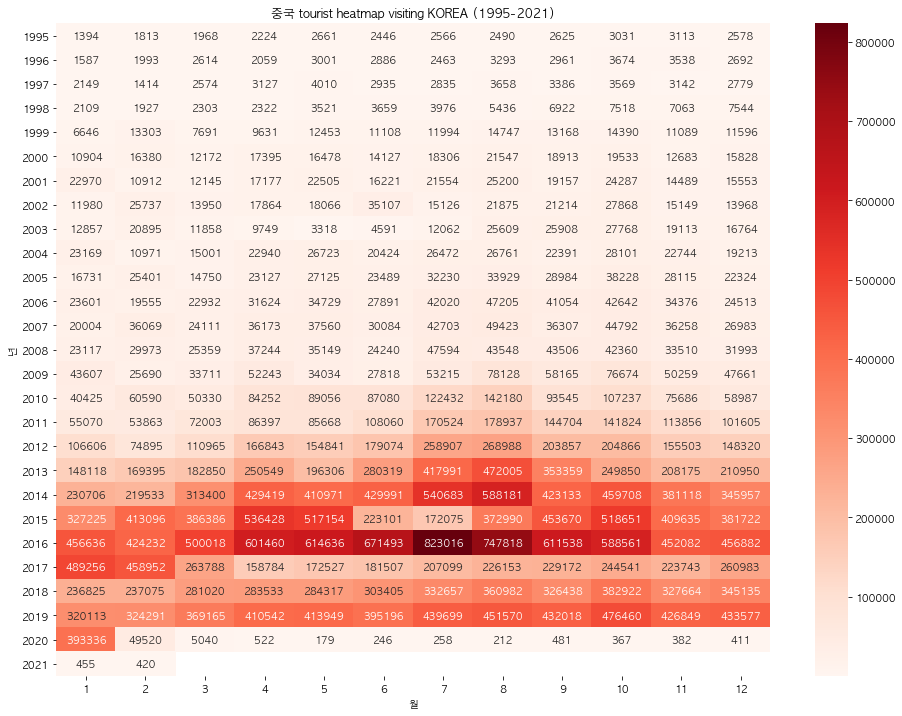

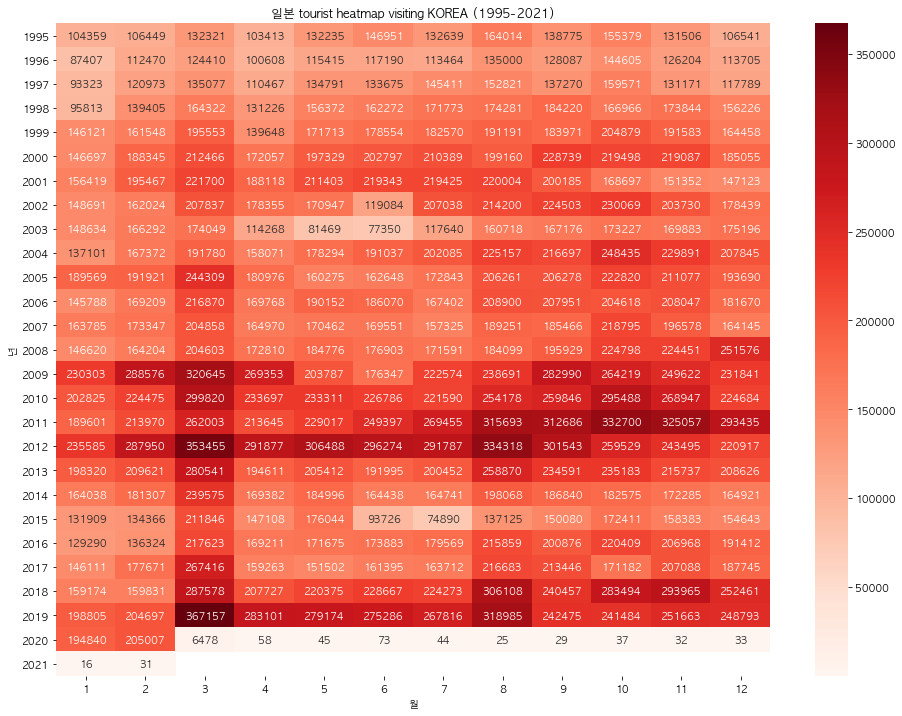

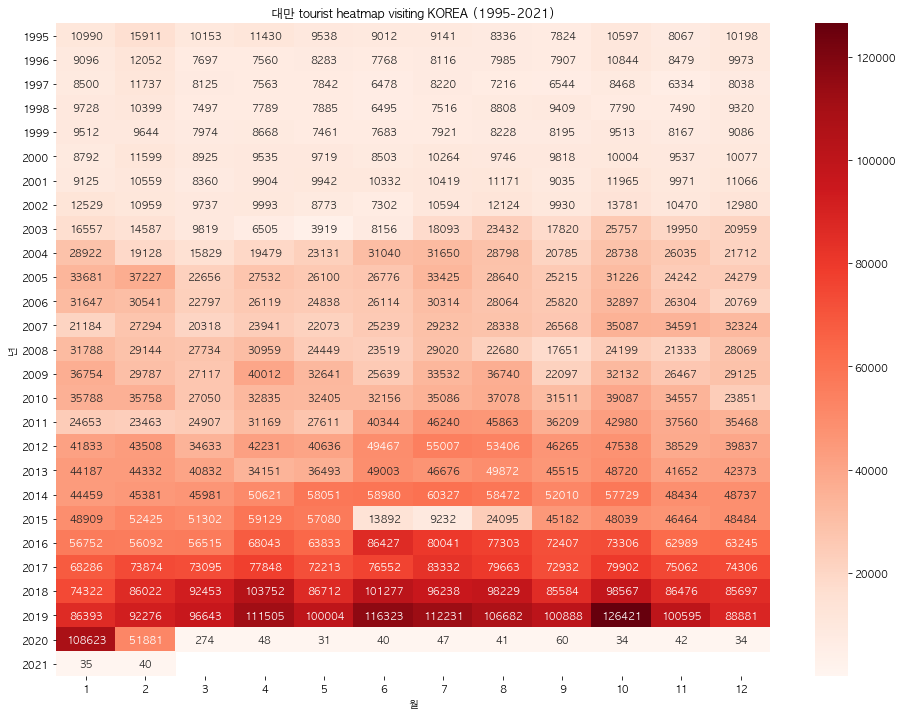

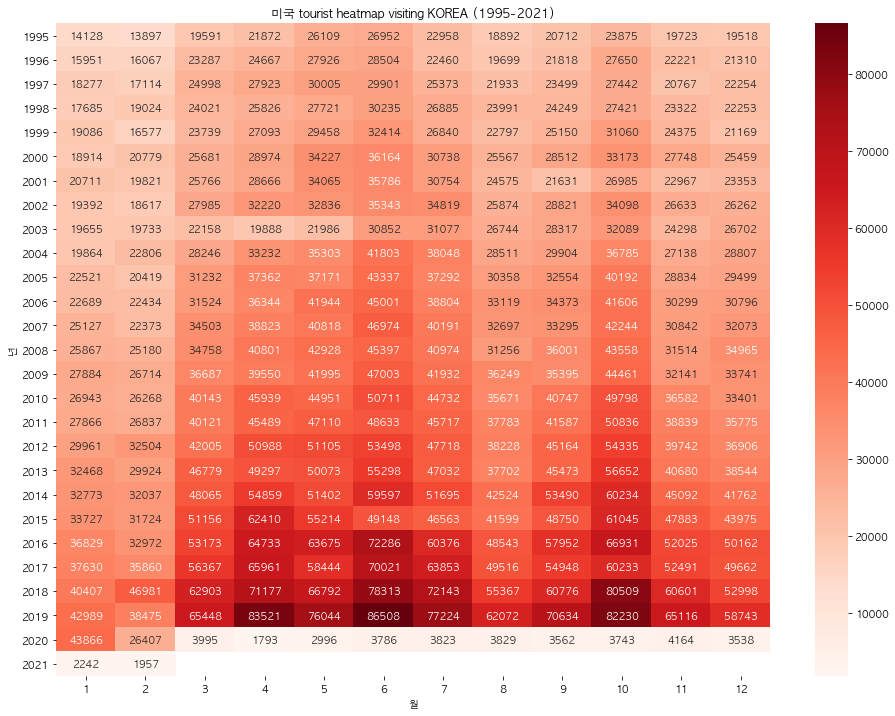

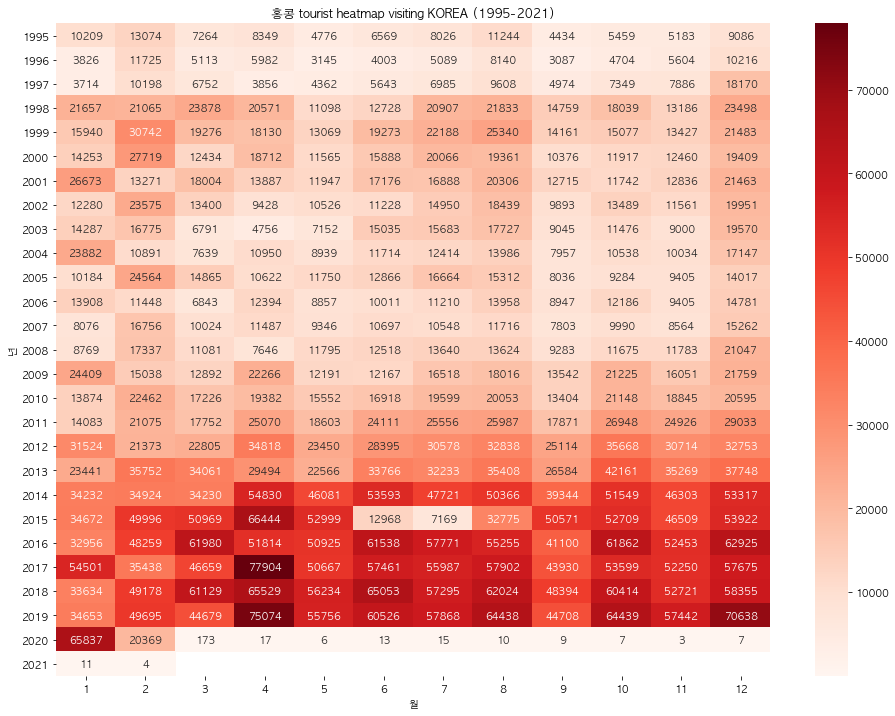

In [774]:
nat_list = ["중국", "일본", "대만", "미국", "홍콩"]

def tourist_nat_heatmap(nat):
    plt.figure(figsize=(16,12))
    df_filter = df[df["국적"] == nat]
    df_pivot = df_filter.pivot_table(values="관광", index="년", columns="월")
    plt.title(f"{nat} tourist heatmap visiting KOREA (1995-2021)")
    sns.heatmap(df_pivot, annot=True, fmt=".0f", cmap="Reds")
    plt.show()
    
for nat in nat_list:
    tourist_nat_heatmap(nat)


## 5. fit and predict for furture (feat.taiwan)

In [775]:
# train_test_spilt
from sklearn.model_selection import train_test_split

df = pd.read_excel("./file/[국적별 관광객 데이터]대만.xlsx")
df.head()


년  월   대륙  국적      계     관광  관광/전체_비율  상용  공용  유학연수   기타    기준년월_l  \
0  1995  1  아시아  대만  11792  10990      6.57  16  14     7  765  19950101   
1  1995  2  아시아  대만  16685  15911      8.81  26   7    36  705  19950201   
2  1995  3  아시아  대만  10919  10153      4.97  43   5     8  710  19950301   
3  1995  4  아시아  대만  12090  11430      6.11  26  12     5  617  19950401   
4  1995  5  아시아  대만  10358   9538      4.40  33  10     9  768  19950501   

    기준년월_s  관광/계_비율  
0  1995-01    93.20  
1  1995-02    95.36  
2  1995-03    92.98  
3  1995-04    94.54  
4  1995-05    92.08

In [776]:
import time
from datetime import date

# df["기준년월"] = pd.to_datetime(df["기준년월_l"], format='%Y%m%d')
df["기준년월_값"] = df["년"]*10000+df["월"]*100
# df.set_index('기준년월', inplace=True)
df = df.drop(["기준년월_s","기준년월_l"],1)
df.head()

년  월   대륙  국적      계     관광  관광/전체_비율  상용  공용  유학연수   기타  관광/계_비율  \
0  1995  1  아시아  대만  11792  10990      6.57  16  14     7  765    93.20   
1  1995  2  아시아  대만  16685  15911      8.81  26   7    36  705    95.36   
2  1995  3  아시아  대만  10919  10153      4.97  43   5     8  710    92.98   
3  1995  4  아시아  대만  12090  11430      6.11  26  12     5  617    94.54   
4  1995  5  아시아  대만  10358   9538      4.40  33  10     9  768    92.08   

     기준년월_값  
0  19950100  
1  19950200  
2  19950300  
3  19950400  
4  19950500

In [777]:
df.corr()

년         월         계        관광  관광/전체_비율        상용  \
년         1.000000 -0.016327  0.730134  0.731181  0.364568  0.119310   
월        -0.016327  1.000000  0.006134  0.006956 -0.160585 -0.012548   
계         0.730134  0.006134  1.000000  0.999897  0.699008  0.117750   
관광        0.731181  0.006956  0.999897  1.000000  0.699100  0.107037   
관광/전체_비율  0.364568 -0.160585  0.699008  0.699100  1.000000  0.065122   
상용        0.119310 -0.012548  0.117750  0.107037  0.065122  1.000000   
공용       -0.255744 -0.052154  0.052642  0.051856  0.123697 -0.068338   
유학연수      0.547882 -0.086570  0.618276  0.615162  0.361625  0.053862   
기타        0.323793 -0.008589  0.646812  0.637490  0.481297  0.425855   
관광/계_비율  -0.198861 -0.004575  0.346554  0.345553  0.540284  0.012790   
기준년월_값    0.999989 -0.011742  0.730209  0.731259  0.363855  0.119260   

                공용      유학연수        기타   관광/계_비율    기준년월_값  
년        -0.255744  0.547882  0.323793 -0.198861  0.999989  
월        -0.052154 -0.086570 -0.008589 -0.004575 -0.011742  
계         0.052642  0.618276  0.646812  0.346554  0.730209  
관광        0.051856  0.615162  0.637490  0.345553  0.731259  
관광/전체_비율  0.123697  0.361625  0.481297  0.540284  0.363855  
상용       -0.068338  0.053862  0.425855  0.012790  0.119260  
공용        1.000000  0.059537  0.099945  0.194933 -0.256000  
유학연수      0.059537  1.000000  0.345030  0.077858  0.547520  
기타        0.099945  0.345030  1.000000  0.379862  0.323775  
관광/계_비율   0.194933  0.077858  0.379862  1.000000 -0.198895  
기준년월_값   -0.256000  0.547520  0.323775 -0.198895  1.000000

In [778]:
# x_train, x_test, y_train, y_test = train_test_split(df.drop(["관광","대륙","국적","년","월"],1), df[["관광","기준년월"]], test_size=0.1, random_state=50)
# x_train, x_test, y_train, y_test = train_test_split(df.drop(["관광","대륙","국적","기준년월"],1), df["관광"], test_size=0.1, random_state=50)
# x_train, x_test, y_train, y_test = train_test_split(df.drop(["관광","대륙","국적","년","월"],1), df[["관광","기준년월"]], test_size=0.1, random_state=50)

x_train, x_test, y_train, y_test = train_test_split(df[["기준년월_값"]], df["관광"], test_size=0.05, random_state=100)

In [779]:
print(x_train.head())
print(y_train.head())
print(x_test.head())
print(y_test.head())

       기준년월_값
27   19970400
242  20150300
187  20100800
201  20111000
224  20130900
27      7563
242    51302
187    37078
201    42980
224    45515
Name: 관광, dtype: int64
       기준년월_값
160  20080500
200  20110900
78   20010700
1    19950200
218  20130300
160    24449
200    36209
78     10419
1      15911
218    40832
Name: 관광, dtype: int64


In [780]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((298, 1), (16, 1), (298,), (16,))

In [781]:
# reset index
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [782]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((298, 1), (16, 1), (298,), (16,))

In [783]:
# period and tourist -> linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [784]:
# func for revaluation
def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': actual})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Index', fontsize=18)
    plt.xlim(min_, max_)
    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

In [785]:
my_predictions = {}
colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 
          'chocolate','gold', 'darkorange', 'seagreen', 'turquoise',
          'steelblue', 'slategray', 'peru', 'midnightblue', 'slateblue',
          'dimgray', 'cadetblue', 'tomato'
         ]

In [786]:
print(x_train)
print(y_train)

       기준년월_값
0    19970400
1    20150300
2    20100800
3    20111000
4    20130900
..        ...
293  20000700
294  19990600
295  20010800
296  20180500
297  19950900

[298 rows x 1 columns]
0       7563
1      51302
2      37078
3      42980
4      45515
       ...  
293    10264
294     7683
295    11171
296    86712
297     7824
Name: 관광, Length: 298, dtype: int64


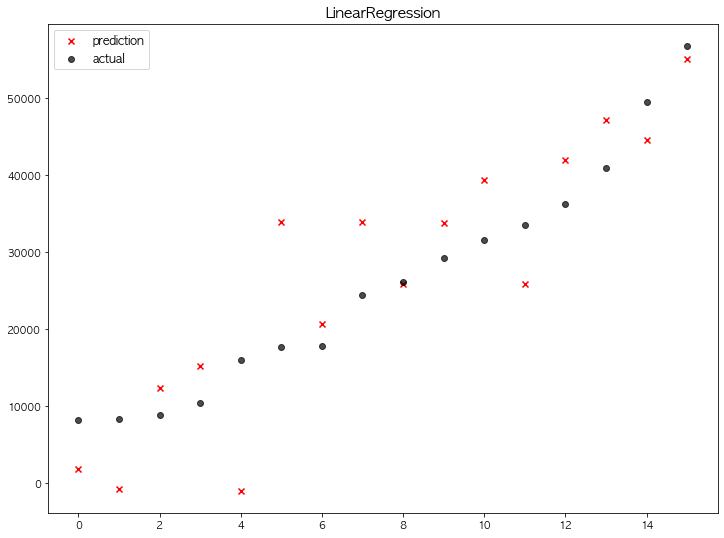

              model           mse
0  LinearRegression  6.523826e+07


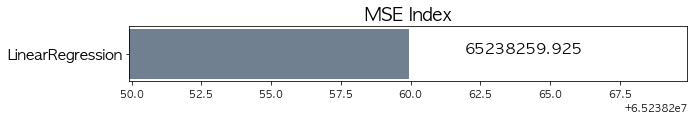

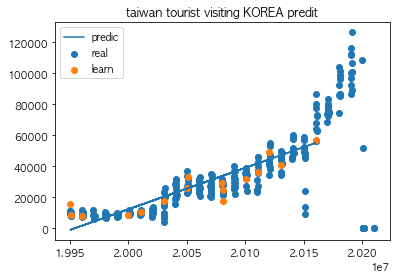

In [787]:
# assignment
model = LinearRegression(n_jobs=-1)
# learn
model.fit(x_train,y_train)
# predict
pred = model.predict(x_test)
# test
mse_eval('LinearRegression', pred, y_test)
# visualize
plt.scatter(x_train,y_train)
plt.scatter(x_test,y_test)
plt.plot(x_test,pred)
plt.title("taiwan tourist visiting KOREA predit")
plt.legend(["predic","real","learn"],loc="best")
plt.show()

In [788]:
# pred for future with Linear Regression
year_pred = [20220100]
pred2 = model.predict([year_pred])
print(f"prediction1 : {round(pred2[0])} of taiwan tourists on {str(year_pred[0])[:4]}-{str(year_pred[0])[4:6]}")

prediction1 : 71130 of taiwan tourists on 2022-01


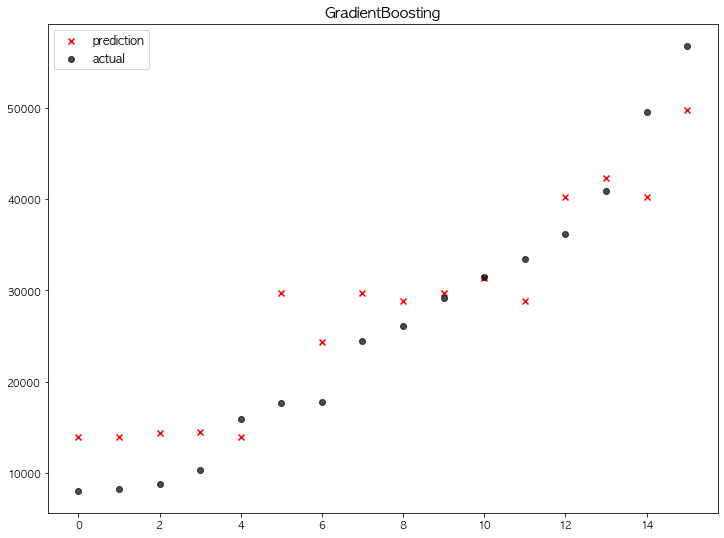

              model           mse
0  LinearRegression  6.523826e+07
1  GradientBoosting  3.230469e+07


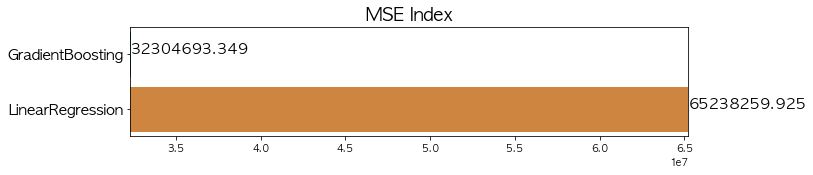

In [789]:
from sklearn.ensemble import GradientBoostingRegressor

# assignment
# gbr = GradientBoostingRegressor(random_state=50, alpha=0.01, max_depth=1, n_estimators=45)
gbr = GradientBoostingRegressor(random_state=50, n_estimators=15)
# learn
gbr.fit(x_train,y_train)
# predict
gbrpred = gbr.predict(x_test)
mse_eval("GradientBoosting", gbrpred, y_test)

In [790]:
# pred for future with GBR
year_pred = [20220100]
pred2 = gbr.predict([year_pred])
print(f"prediction2 : {round(pred2[0])} of taiwan tourists on {str(year_pred[0])[:4]}-{str(year_pred[0])[4:6]}")

prediction2 : 6852 of taiwan tourists on 2022-01


0.9138753570343695


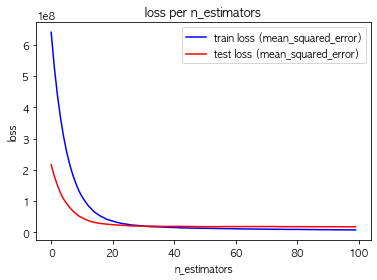

best_n_estimators : 96
test_losses[best_n_estimators] : 17909102.428772323


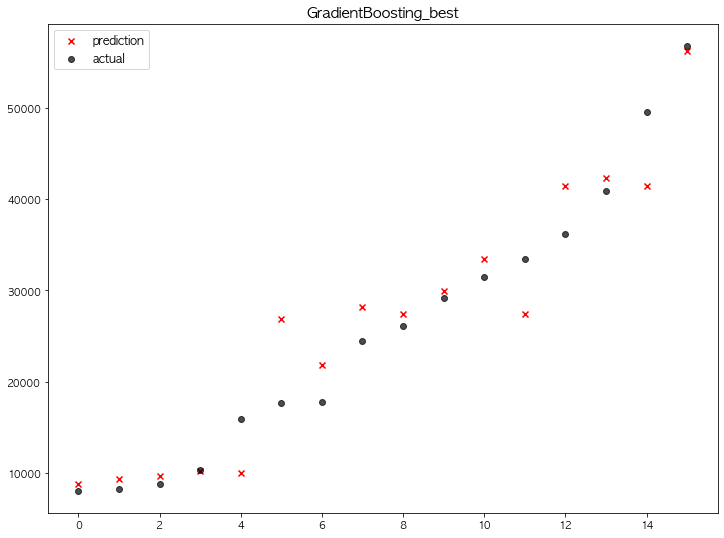

                   model           mse
0       LinearRegression  6.523826e+07
1       GradientBoosting  3.230469e+07
2  GradientBoosting_best  1.797402e+07


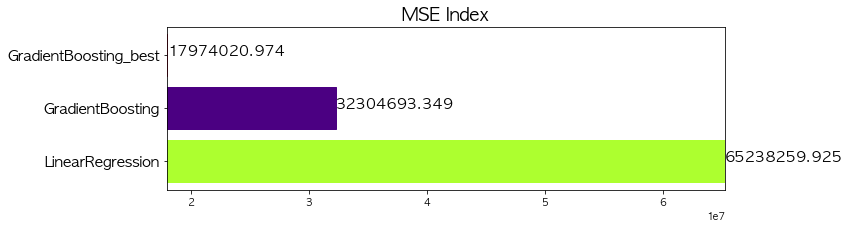

In [793]:
# for best n_estimator of GBR
from sklearn.metrics import mean_squared_error

model = GradientBoostingRegressor()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

train_losses = [mean_squared_error(y_train, y_predict) for y_predict in model.staged_predict(x_train)]
test_losses = [mean_squared_error(y_test, y_predict) for y_predict in model.staged_predict(x_test)]

plt.plot(range(len(train_losses)), train_losses, color='blue', label='train loss (mean_squared_error)')
plt.plot(range(len(test_losses)), test_losses, color='red', label='test loss (mean_squared_error)')
plt.title('loss per n_estimators') 
plt.xlabel('n_estimators')
plt.ylabel('loss')
plt.legend() #loc='upper left')
plt.show()

# model predic
best_n_estimators = np.argmin(test_losses)
print(f"best_n_estimators : {best_n_estimators}")
print(f"test_losses[best_n_estimators] : {test_losses[best_n_estimators]}")

gbc_b = GradientBoostingRegressor(random_state=50, n_estimators=best_n_estimators)
gbc_b.fit(x_train, y_train)
pred = gbc_b.predict(x_test)
mse_eval("GradientBoosting_best", pred, y_test)


In [795]:
# pred for future with GBR best_e
year_pred = [20220100]
pred3 = gbc_b.predict([year_pred])
print(f"prediction3 : {round(pred3[0])} of taiwan tourists on {str(year_pred[0])[:4]}-{str(year_pred[0])[4:6]}")

prediction3 : 401 of taiwan tourists on 2022-01


## conclusion

< results >
- date : 2022/01
- num of tourists
    1. linear : 71,130
    2. GBR (n_esti=15) : 6,852
    3. GBR (n_esti=96) : 401
    4. GBR (n_esti=115) : 307

< flight >
- 16,800 seats/month
- 200 seats * 21 flight * 4 weeks
 - seats avg by A330-300 
 - num of flight : TPE-ICN (CI 160, CI162, 7C2602, KE692, OZ712, BR160, TR896)

< remark > <br>
- predicted num of tourist is still under num of flight seats, so that tourist could get flight ticket
- even lot of travel facilities such as hotel, mobilities have been stopped for a while, be able to control number of tourist that compare with peak-season's
- nowaday TPE-ROR tour has been started since 21/4/14, it seem to be positive for travel inderstry (no isolation, but need COVID-19 PCR test)
- however, under COVID-19 has got many limitation such as isolation, inoculation, visa etc
- taiwan CDC has started inoculation since 21/4/23 for Taiwanese public, but not all of them
- since 3rd covid wave in korea, taiwan CDC decided to get rid of korea from Low/Medium-lisk list, it makes public have negetive impression of korea
- url : https://www.cdc.gov.tw/En/Bulletin/Detail/fxEUdxER3An77kQPOyprKw?typeid=158
